In [32]:
import requests
import pandas as pd
import json
import geopandas as gpd
import io
from shapely.geometry import shape
import urllib.request as request
import json
import datetime
import os

def round_time(dt=None, date_delta=datetime.timedelta(minutes=1), to='average'):
    """
    Round a datetime object to a multiple of a timedelta
    dt : datetime.datetime object, default now.
    dateDelta : timedelta object, we round to a multiple of this, default 1 minute.
    from:  http://stackoverflow.com/questions/3463930/how-to-round-the-minute-of-a-datetime-object-python
    """
    round_to = date_delta.total_seconds()
    if dt is None:
        dt = datetime.now()
    seconds = (dt - dt.min).seconds

    if seconds % round_to == 0 and dt.microsecond == 0:
        rounding = (seconds + round_to / 2) // round_to * round_to
    else:
        if to == 'up':
            # // is a floor division, not a comment on following line (like in javascript):
            rounding = (seconds + dt.microsecond/1000000 + round_to) // round_to * round_to
        elif to == 'down':
            rounding = seconds // round_to * round_to
        else:
            rounding = (seconds + round_to / 2) // round_to * round_to

    return dt + datetime.timedelta(0, rounding - seconds, - dt.microsecond)


# substract the different between utc and local time bc download data is in UTC
dt = datetime.datetime.now()
utc = datetime.datetime.now(datetime.UTC)
delta = datetime.timedelta(hours=dt.hour -utc.hour, minutes=20)
dt_utc = dt - delta
# get current time to construct the string to download data
current_dateTime = round_time(dt=dt_utc, date_delta=datetime.timedelta(minutes=10), to='down')

year = str(current_dateTime.year) # 2024
month = "0"+str(current_dateTime.month) # 9
day = str(current_dateTime.day) # 20

hour = str(current_dateTime.hour) # 11
minute = str(current_dateTime.minute) # 27


start = "start=" + year + "-" + month + "-" + day + "T" + "00%3A00%3A00.000Z"
end = "end=" + year + "-" + month + "-" + day + "T" + hour + "%3A" + minute + "%3A00.000Z"

file_name = current_dateTime.strftime("%Y%m%d-%H%M%S") + "_10min_TAWES.csv" 
%store file_name
# # API CALLS:
# All Geosphere datasets
# "https://dataset.api.hub.geosphere.at/v1/datasets"

# url_tawes = 'https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-10min?parameters=tl&parameters=tlmax&parameters=tlmin&start=2020-12-12T00%3A00%3A00.000Z&end=2024-08-14T15%3A00%3A00.000Z,station_ids=93&output_format=csv&filename=Messstationen+Zehnminutendaten+v2+Datensatz_20201212T0000_20240814T1500'
# url_curr_tawes = 'https://dataset.api.hub.geosphere.at/v1/station/current/tawes-v1-10min?parameters=TL,TP,TLMAX,station_ids=11035'

# data_tawes = "https://dataset.api.hub.geosphere.at/v1/station/current/tawes-v1-10min?parameters="
# meta_tawes = "https://dataset.api.hub.geosphere.at/v1/station/current/tawes-v1-10min/metadata"

# url_snowgrid = 'https://dataset.api.hub.geosphere.at/v1/grid/historical/snowgrid_cl-v2-1d-1km?parameters=swe_tot&start=2024-08-12&end=2024-08-13&bbox=46.16132856869247,9.393909734939893,49.177527691779716,17.382180045432914'


url_date = ("https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-10min?parameters=tl,tlmax,rf,dd,ddx,ffx&"+
       # "start=2024-08-16T00%3A00%3A00.000Z&end=2024-08-16T16%3A10%3A00.000Z"+
       # "start=2024-08-22T00%3A00%3A00.000Z&end=2024-08-22T17%3A50%3A00.000Z"
       start + "&" + end +
       "&station_ids=1,2,3,4,5,6,7,8,9,10,11,12,13"+
       ",14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,37,38,39,40,42,43,44,46,47,48,49,50,51,52,53,54,"+
       "55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,85,86,87,88,89,90,91,92,93,94"+
       ",95,97,98,100,101,102,103,104,105,106,107,108,109,111,112,113,115,116,118,119,120,121,122,124,125,126,127,129"+
       ",130,131,132,133,134,136,137,138,139,140,141,142,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158"+
       ",159,160,161,162,163,164,165,166,167,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187"+
       ",188,189,190,192,193,195,196,197,198,199,200,201,202,203,204,205,206,210,213,214,215,217,218,220,221,222,500"+
       ",726,905,1401,1415,1416,1601,1602,1730,1802,1906,1920,2114,2115,2116,2117,2207,2401,2415,2430,2503,2601,2602"+
       ",2902,2910,3111,3202,3315,3425,3520,3702,3805,3811,4026,4030,4081,4115,4125,4126,4224,4305,4501,4515,4601,4611"+
       ",4705,4802,4815,4821,4905,5000,5012,5116,5130,5315,5316,5412,5413,5421,5604,5609,5625,5701,5725,5735,5802,5805"+
       ",5820,5870,5881,5882,5904,5917,5925,5935,5972,5990,6102,6111,6300,6305,6411,6412,6415,6430,6501,6512,6540,6611"+
       ",6620,6621,6803,6804,7002,7012,7013,7110,7221,7301,7305,7500,7505,7531,7604,7610,7641,7653,7704,7710,7714,7890"+
       ",7905,7906,7912,7955,7956,8301,8805,8806,9016,9019,9105,9110,9211,9215,9406,9501,9511,9512,9605,9606,9609,9618"+
       ",9640,9643,9700,9801,9811,9911,9919,9925,10005,10111,10200,10401,10412,10415,10500,10510,10531,10550,10607"+
       ",10710,10720,11104,11106,11112,11114,11115,11116,11135,11146,11203,11301,11305,11311,11402,11410,11505,11603,"+
       "11706,11803,11804,11901,12015,12202,12203,12215,12216,12231,12302,12311,12322,12323,12351,12504,12513,12530,"+
       "12615,12616,12711,12720,12721,12811,13116,13120,13250,13302,13305,13308,13312,13401,13515,13605,13606,13640,"+
       "13702,13706,13707,13805,13811,13906,13907,14103,14104,14115,14302,14305,14308,14311,14403,14513,14521,14603,"+
       "14622,14631,14701,14801,14802,14812,14822,14825,14833,14912,15001,15002,15105,15210,15321,15344,15402,15411"+
       ",15430,15501,15509,15600,15610,15640,15702,15712,15715,15721,15901,15912,15920,16015,16101,16308,16400,16411"+
       ",16412,16413,16414,16421,16501,16511,16521,16601,16702,16711,16800,16905,16906,17002,17005,17102,17301,17315"+
       ",17320,17701,17901,18001,18111,18121,18122,18210,18225,18231,18402,18502,18601,18622,18705,18805,18905,18906"+
       ",19021,19204,19205,19505,19700,19711,19720,19821,19911,20002,20011,20021,20101,20105,20123,20202,20209,20211"+
       ",20212,20220,20270,20408,20411,20412,20901,20902,20903,21101,21300"+
       "&filename=" + file_name +
       # "Messstationen+Zehnminutendaten+v2+Datensatz_20240816T0000_20240816T1610"+
       "&output_format=csv")





# &filename=Messstationen+Zehnminutendaten+v2+Datensatz_20240816T0000_20240816T1610"



with open(file_name, 'wb') as out_file:
    content = requests.get(url_date).content
    out_file.write(content)


# print(start)
# print(end)
# print(file_name)
# print("'" + url_date + "'")
# os.system("curl -o " + file_name + " " + "'" + url_date + "'")
# end=2024-08-16T16%3A10%3A00.000Z"

Stored 'file_name' (str)


In [33]:
print(url_date)

https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-10min?parameters=tl,tlmax,rf,dd,ddx,ffx&start=2024-08-26T00%3A00%3A00.000Z&end=2024-08-26T19%3A0%3A00.000Z&station_ids=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,37,38,39,40,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,85,86,87,88,89,90,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,109,111,112,113,115,116,118,119,120,121,122,124,125,126,127,129,130,131,132,133,134,136,137,138,139,140,141,142,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,189,190,192,193,195,196,197,198,199,200,201,202,203,204,205,206,210,213,214,215,217,218,220,221,222,500,726,905,1401,1415,1416,1601,1602,1730,1802,1906,1920,2114,2115,2116,2117,2207,2401,2415,2430,2503,2601,2602,2902,2910,3111,3202,331

'https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-10min?parameters=tl,tlmax,rf,dd,ddx,ffx&start=2024-08-16T00%3A00%3A00.000Z&end=2024-08-16T16%3A10%3A00.000Z&station_ids=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,37,38,39,40,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,80,81,82,83,85,86,87,88,89,90,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,109,111,112,113,115,116,118,119,120,121,122,124,125,126,127,129,130,131,132,133,134,136,137,138,139,140,141,142,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,189,190,192,193,195,196,197,198,199,200,201,202,203,204,205,206,210,213,214,215,217,218,220,221,222,500,726,905,1401,1415,1416,1601,1602,1730,1802,1906,1920,2114,2115,2116,2117,2207,2401,2415,2430,2503,2601,2602,2902,2910,3111,3202,3

<Axes: >

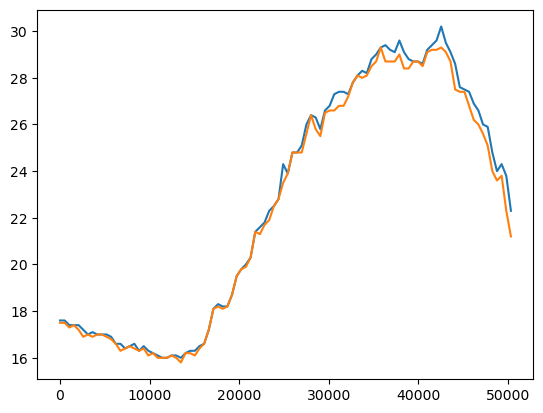

In [26]:
print("'"+url+"'")
test_data = pd.read_csv("test.csv")
test_data.loc[test_data.station == 1]['tlmax'].plot()
test_data.loc[test_data.station == 1]['tl'].plot()

In [43]:
url_meta = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-10min/metadata"

source = requests.get(url_meta).json()
# print(source)

station_parameters = ""
for parameter in source['parameters']:
    station_parameters += parameter["name"] + ","
station_parameters = station_parameters.rstrip(station_parameters[-1])
all_station_parameters = station_parameters

# print(all_station_parameters)

station_list = source["stations"]
stations = {}
for station in station_list:
    stations[station["id"]] = tuple(
       float((str(station[coord])))
        for coord in ("lat", "lon")
                    )
    
df = pd.DataFrame(station_list)
df.to_csv('station_info.csv')

# source = requests.get(url_meta)
# # extract all parameters as a list
# parameter_list = json.loads(source)["parameters"]
# station_parameters = ""
# for parameter in parameter_list:
#     station_parameters += parameter["name"] + ","
# station_parameters = station_parameters.rstrip(station_parameters[-1])
# all_station_parameters = station_parameters

# print(all_station_parameters)

# # extract all stations available
# # extract all stations out of parameters
# station_list = json.loads(source)["stations"]
# stations = {}
# for station in station_list:
#     stations[station["id"]] = tuple(
#        float((str(station[coord])))
#         for coord in ("lat", "lon", "name")
#                     )
    
# print(stations.keys())


